In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 30
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(10000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    dtype=tf.float64, u_tau_scale=1.)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=50, rel_tol=1e-4, learning_rate=.1)



W0520 20:42:52.810560 4511276480 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 53.03543607810065
Epoch 1: average-batch loss: 46.74767179784202 last batch loss: 41.349248126372736
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 40.705551370033355 last batch loss: 38.440934743493614
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 37.47284168630184 last batch loss: 36.853154023887825
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 36.20279202787128 last batch loss: 36.117741554328134
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 35.91390550949213 last batch loss: 35.85904882993537
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 35.91749683130479 last batch loss: 35.94753222372117
Epoch 7: average-batch loss: 35.91655752835414 last batch loss: 35.9052600129012
Epoch 8: average-batch loss: 35.92223401517874 last batch loss: 35.86016628766732
We are in a loss plateau learning rate: 0.025 loss: 35.947001681941444
Restoring from a checkpoint - loss: 3

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 1126954.5540905208, 'se': 1219.792329586554, 'lppd': -410722.2804741803, 'pwaic': 152754.99657108015}


# Plot the factor encoding matrix

In [7]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.norm_factor).numpy().T})

In [8]:
factor.intercept_matrix()

<tf.Tensor: shape=(1, 30), dtype=float64, numpy=
array([[0.9738345 , 0.9733772 , 0.96265538, 0.9714945 , 0.97194532,
        0.96826485, 0.98081131, 0.96143767, 0.9680863 , 0.9675833 ,
        0.97096343, 0.96016487, 0.9661321 , 0.96274279, 0.96009966,
        0.97557361, 0.96277729, 0.96472603, 0.95819257, 0.97435714,
        0.95631556, 0.96687748, 0.9478884 , 0.96198648, 0.97521447,
        0.97407986, 0.96599779, 0.95268722, 0.95842456, 0.96471314]])>

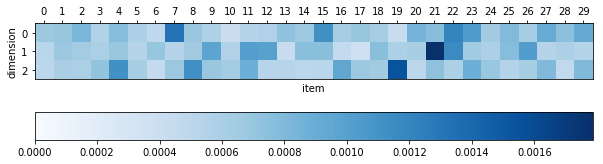

In [9]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


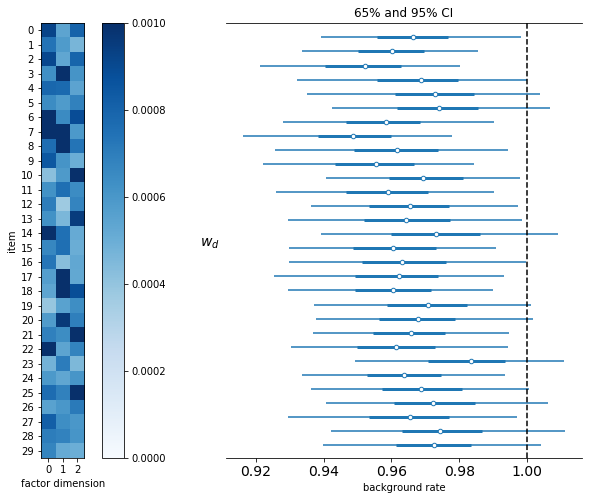

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.001, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

In [11]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 30), dtype=float64, numpy=
array([[0.2295838 , 0.22699055, 0.23037702, 0.22745738, 0.23057952,
        0.23061713, 0.22928431, 0.22965553, 0.22800302, 0.22740484,
        0.23012774, 0.2376664 , 0.22961367, 0.23465139, 0.22842681,
        0.22180072, 0.2347027 , 0.23105253, 0.22848086, 0.22281395,
        0.23352763, 0.23357269, 0.23485462, 0.22767362, 0.22721853,
        0.23123941, 0.22706278, 0.23112237, 0.22506994, 0.23538265],
       [0.7704162 , 0.77300945, 0.76962298, 0.77254262, 0.76942048,
        0.76938287, 0.77071569, 0.77034447, 0.77199698, 0.77259516,
        0.76987226, 0.7623336 , 0.77038633, 0.76534861, 0.77157319,
        0.77819928, 0.7652973 , 0.76894747, 0.77151914, 0.77718605,
        0.76647237, 0.76642731, 0.76514538, 0.77232638, 0.77278147,
        0.76876059, 0.77293722, 0.76887763, 0.77493006, 0.76461735]])>

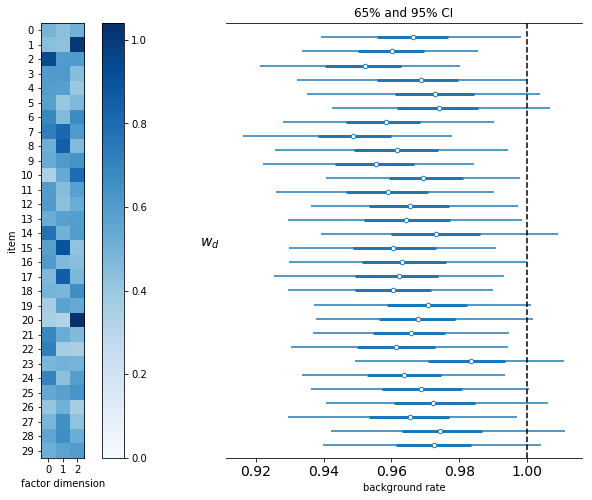

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.show()
